# Importing Libraries and Dataset 

In [35]:
import os 
import time 
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Callable, Optional, Type, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision import datasets

In [36]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure all images are 32x32
    transforms.ToTensor(),
])

# Download and create the CIFAR-10 train and test datasets
train_ds = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_ds = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

print(f'Train Samples: {len(train_ds)} || Test Samples: {len(test_ds)} || Classes: {len(train_ds.classes)}')

Files already downloaded and verified
Files already downloaded and verified
Train Samples: 50000 || Test Samples: 10000 || Classes: 10


# Building the Model

In [37]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self,
                 in_chans: int,
                 out_chans: int,
                 kernel_size: int,
                 stride: int,
                 padding: int):
        
        super(DepthwiseSeparableConv, self).__init__()

        self.depthwise = nn.Conv2d(in_chans, in_chans, kernel_size=kernel_size, stride=stride,
                                    padding=padding, groups=in_chans, bias=False)

        self.pointwise = nn.Conv2d(in_chans, out_chans, kernel_size=1, bias=False)

    def forward(self, x):
        
        x = self.depthwise(x)
        x = self.pointwise(x)
        
        return x

class AttentionModulatedConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(AttentionModulatedConv, self).__init__()
        
        self.out_channels = out_channels
        self.value_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.conv = DepthwiseSeparableConv(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        V = self.value_conv(x).view(batch_size, -1, height * width)
        conv_output = self.conv(x).view(batch_size, self.out_channels, -1)
        
        modulated_conv = F.softmax(conv_output, dim=1) * V

        return modulated_conv

    
class ModulatedModel(nn.Module):
    def __init__(self):
        super(ModulatedModel, self).__init__()
        self.attention_conv = AttentionModulatedConv(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        
        x = self.attention_conv(x)
        x = self.pool(torch.relu(x))
        x = x.view(-1, 32 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [38]:
torch.manual_seed(42)

model = ModulatedModel()
sample = torch.randn(16, 3, 32, 32)
output = model(sample)

print(f'Input Shape: {sample.shape} || Output Shape: {output.shape}')

Input Shape: torch.Size([16, 3, 32, 32]) || Output Shape: torch.Size([16, 10])


# Training the Model

In [39]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):
       
        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

In [40]:
import torch.optim as optim
import csv
from tqdm import tqdm 
import time as time

torch.manual_seed(42)

model = ModulatedModel()

out_dir = './task6_6-output'
os.makedirs(out_dir, exist_ok=True)
epochs = 20
lr = 3e-4
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'
model.to(device)

params = count_trainable_params(model)
print(f'Finetuning {params*1e-6:.3f}M params on {device} for {epochs} epochs ...\n')

csv_file = os.path.join(out_dir, 'log.csv')
model_file = os.path.join(out_dir, 'weights.pth')

with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  

        train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = eval_step(model, test_dl, criterion, device)
        
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc])
        
        epoch_duration = time.time() - start_time

        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Val Acc: {val_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")
    
    torch.save(model.state_dict(), model_file)

Finetuning 1.050M params on cuda for 20 epochs ...



Epochs:   0%|           | Epoch: 0/20 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.9887 Acc: 0.2858
Evaluation: [313/313] Loss: 1.8349 Acc: 0.3545

Epochs:   5%|▌          | Epoch: 1/20 | Time: 00:11 < 03:31 | 11.14s/it


============ Epoch 1 --> Train Acc: 0.2858 || Val Acc: 0.3545 || Time: 11.14 s ============

Training: [1563/1563] Loss: 1.7851 Acc: 0.3709
Evaluation: [298/313] Loss: 1.7146 Acc: 0.3980

Epochs:  10%|█          | Epoch: 2/20 | Time: 00:22 < 03:17 | 10.99s/it

Evaluation: [313/313] Loss: 1.7127 Acc: 0.3974
============ Epoch 2 --> Train Acc: 0.3709 || Val Acc: 0.3974 || Time: 10.89 s ============

Training: [1563/1563] Loss: 1.6810 Acc: 0.4048
Evaluation: [301/313] Loss: 1.6250 Acc: 0.4261

Epochs:  15%|█▌         | Epoch: 3/20 | Time: 00:32 < 03:05 | 10.93s/it

Evaluation: [313/313] Loss: 1.6235 Acc: 0.4256
============ Epoch 3 --> Train Acc: 0.4048 || Val Acc: 0.4256 || Time: 10.86 s ============

Training: [1563/1563] Loss: 1.6049 Acc: 0.4331
Evaluation: [292/313] Loss: 1.5633 Acc: 0.4390

Epochs:  20%|██         | Epoch: 4/20 | Time: 00:44 < 02:56 | 11.06s/it

Evaluation: [313/313] Loss: 1.5636 Acc: 0.4376
============ Epoch 4 --> Train Acc: 0.4331 || Val Acc: 0.4376 || Time: 11.24 s ============

Training: [1563/1563] Loss: 1.5504 Acc: 0.4497
Evaluation: [313/313] Loss: 1.5220 Acc: 0.4567

Epochs:  25%|██▌        | Epoch: 5/20 | Time: 00:54 < 02:44 | 10.96s/it


============ Epoch 5 --> Train Acc: 0.4497 || Val Acc: 0.4567 || Time: 10.79 s ============

Training: [1563/1563] Loss: 1.5113 Acc: 0.4645
Evaluation: [309/313] Loss: 1.4958 Acc: 0.4719

Epochs:  30%|███        | Epoch: 6/20 | Time: 01:05 < 02:32 | 10.91s/it

Evaluation: [313/313] Loss: 1.4951 Acc: 0.4712
============ Epoch 6 --> Train Acc: 0.4645 || Val Acc: 0.4712 || Time: 10.82 s ============

Training: [1563/1563] Loss: 1.4800 Acc: 0.4755
Evaluation: [313/313] Loss: 1.4672 Acc: 0.4788


Epochs:  35%|███▌       | Epoch: 7/20 | Time: 01:16 < 02:22 | 10.94s/it

============ Epoch 7 --> Train Acc: 0.4755 || Val Acc: 0.4788 || Time: 11.00 s ============

Training: [1563/1563] Loss: 1.4547 Acc: 0.4856
Evaluation: [308/313] Loss: 1.4472 Acc: 0.4916

Epochs:  40%|████       | Epoch: 8/20 | Time: 01:27 < 02:11 | 10.98s/it

Evaluation: [313/313] Loss: 1.4472 Acc: 0.4900
============ Epoch 8 --> Train Acc: 0.4856 || Val Acc: 0.4900 || Time: 11.05 s ============

Training: [1563/1563] Loss: 1.4321 Acc: 0.4923
Evaluation: [304/313] Loss: 1.4322 Acc: 0.4926

Epochs:  45%|████▌      | Epoch: 9/20 | Time: 01:38 < 02:00 | 10.93s/it

Evaluation: [313/313] Loss: 1.4331 Acc: 0.4899
============ Epoch 9 --> Train Acc: 0.4923 || Val Acc: 0.4899 || Time: 10.81 s ============

Training: [1563/1563] Loss: 1.4110 Acc: 0.5007
Evaluation: [308/313] Loss: 1.4144 Acc: 0.4983

Epochs:  50%|█████      | Epoch: 10/20 | Time: 01:49 < 01:49 | 10.96s/it

Evaluation: [313/313] Loss: 1.4142 Acc: 0.4974
============ Epoch 10 --> Train Acc: 0.5007 || Val Acc: 0.4974 || Time: 11.04 s ============

Training: [1563/1563] Loss: 1.3924 Acc: 0.5071
Evaluation: [310/313] Loss: 1.4005 Acc: 0.5052

Epochs:  55%|█████▌     | Epoch: 11/20 | Time: 02:00 < 01:38 | 10.92s/it

Evaluation: [313/313] Loss: 1.4004 Acc: 0.5042
============ Epoch 11 --> Train Acc: 0.5071 || Val Acc: 0.5042 || Time: 10.81 s ============

Training: [1563/1563] Loss: 1.3742 Acc: 0.5127
Evaluation: [304/313] Loss: 1.3857 Acc: 0.5110

Epochs:  60%|██████     | Epoch: 12/20 | Time: 02:11 < 01:26 | 10.87s/it

Evaluation: [313/313] Loss: 1.3871 Acc: 0.5087
============ Epoch 12 --> Train Acc: 0.5127 || Val Acc: 0.5087 || Time: 10.75 s ============

Training: [1563/1563] Loss: 1.3579 Acc: 0.5203
Evaluation: [307/313] Loss: 1.3861 Acc: 0.5083

Epochs:  65%|██████▌    | Epoch: 13/20 | Time: 02:22 < 01:16 | 10.99s/it

Evaluation: [313/313] Loss: 1.3861 Acc: 0.5058
============ Epoch 13 --> Train Acc: 0.5203 || Val Acc: 0.5058 || Time: 11.26 s ============

Training: [1563/1563] Loss: 1.3437 Acc: 0.5258
Evaluation: [299/313] Loss: 1.3647 Acc: 0.5181

Epochs:  70%|███████    | Epoch: 14/20 | Time: 02:33 < 01:05 | 10.98s/it

Evaluation: [313/313] Loss: 1.3649 Acc: 0.5167
============ Epoch 14 --> Train Acc: 0.5258 || Val Acc: 0.5167 || Time: 10.95 s ============

Training: [1563/1563] Loss: 1.3292 Acc: 0.5294
Evaluation: [299/313] Loss: 1.3626 Acc: 0.5208

Epochs:  75%|███████▌   | Epoch: 15/20 | Time: 02:44 < 00:54 | 10.96s/it

Evaluation: [313/313] Loss: 1.3628 Acc: 0.5190
============ Epoch 15 --> Train Acc: 0.5294 || Val Acc: 0.5190 || Time: 10.91 s ============

Training: [1563/1563] Loss: 1.3163 Acc: 0.5350
Evaluation: [301/313] Loss: 1.3588 Acc: 0.5212

Epochs:  80%|████████   | Epoch: 16/20 | Time: 02:55 < 00:43 | 10.99s/it

Evaluation: [313/313] Loss: 1.3604 Acc: 0.5197
============ Epoch 16 --> Train Acc: 0.5350 || Val Acc: 0.5197 || Time: 11.07 s ============

Training: [1563/1563] Loss: 1.3029 Acc: 0.5411
Evaluation: [300/313] Loss: 1.3474 Acc: 0.5226

Epochs:  85%|████████▌  | Epoch: 17/20 | Time: 03:06 < 00:32 | 10.92s/it

Evaluation: [313/313] Loss: 1.3488 Acc: 0.5210
============ Epoch 17 --> Train Acc: 0.5411 || Val Acc: 0.5210 || Time: 10.76 s ============

Training: [1563/1563] Loss: 1.2923 Acc: 0.5440
Evaluation: [307/313] Loss: 1.3469 Acc: 0.5279

Epochs:  90%|█████████  | Epoch: 18/20 | Time: 03:16 < 00:21 | 10.86s/it

Evaluation: [313/313] Loss: 1.3464 Acc: 0.5263
============ Epoch 18 --> Train Acc: 0.5440 || Val Acc: 0.5263 || Time: 10.72 s ============

Training: [1563/1563] Loss: 1.2800 Acc: 0.5476
Evaluation: [308/313] Loss: 1.3305 Acc: 0.5285

Epochs:  95%|█████████▌ | Epoch: 19/20 | Time: 03:27 < 00:10 | 10.92s/it

Evaluation: [313/313] Loss: 1.3305 Acc: 0.5264
============ Epoch 19 --> Train Acc: 0.5476 || Val Acc: 0.5264 || Time: 11.05 s ============

Training: [1563/1563] Loss: 1.2679 Acc: 0.5535
Evaluation: [313/313] Loss: 1.3353 Acc: 0.5237

Epochs: 100%|██████████ | Epoch: 20/20 | Time: 03:38 < 00:00 | 10.94s/it


============ Epoch 20 --> Train Acc: 0.5535 || Val Acc: 0.5237 || Time: 10.82 s ============



# Visualising Feature Maps

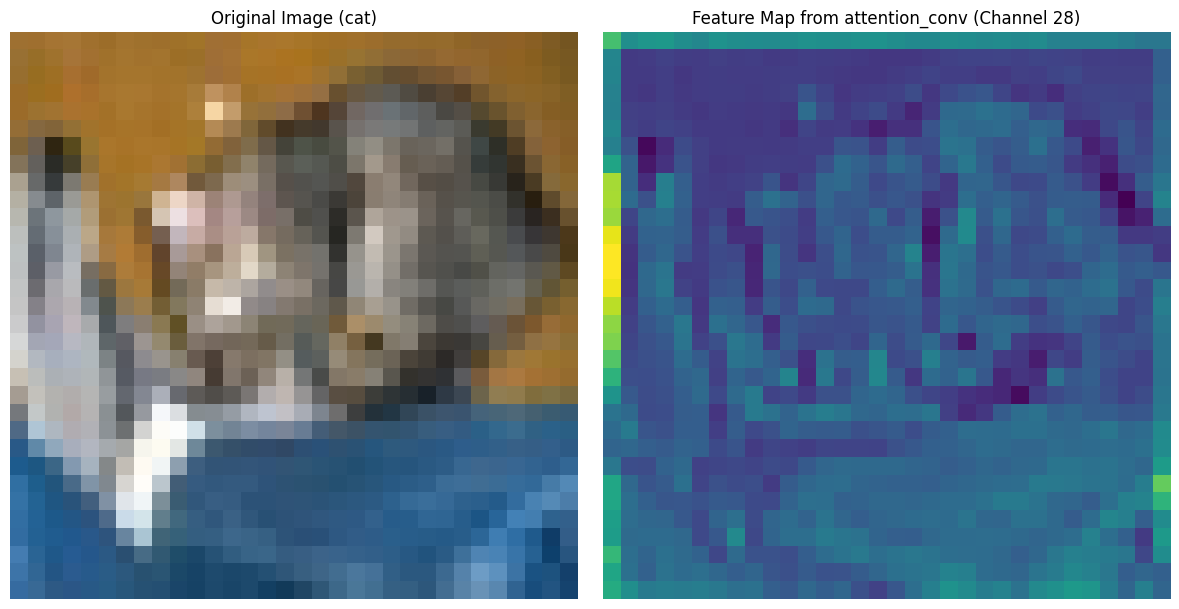

In [44]:
torch.manual_seed(42)

def visualize_feature_map(model, test_dl):
    classes = test_ds.classes
    model.eval()
    images, labels = next(iter(test_dl))
    
    image = images[0].unsqueeze(0).to(device)
    label = labels[0].item()
    label = classes[label]

    with torch.no_grad():
        feature_map = model.attention_conv(image)

    np_image = images[0].permute(1, 2, 0).numpy()

    feature_map_reshaped = feature_map.view(32, 32, 32)  # Reshape the spatial dimension
    random_channel = torch.randint(0, 32, (1,)).item()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(np_image, 0, 1))  # Clip values to valid range [0, 1]
    plt.title(f'Original Image ({label})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    feature_map_img = feature_map_reshaped[random_channel].cpu().numpy()
    plt.imshow(feature_map_img, cmap='viridis')
    plt.title(f'Feature Map from attention_conv (Channel {random_channel})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('./task6_6.png')
    plt.show()

visualize_feature_map(model, test_dl)